# Tutorial 5: Fourier Neural Operator Learning

In this tutorial we are going to solve the Darcy flow 2d problem, presented in [Fourier Neural Operator for
Parametric Partial Differential Equation](https://openreview.net/pdf?id=c8P9NQVtmnO). First of all we import the modules needed for the tutorial. Importing `scipy` is needed for input output operation, run `pip install scipy` for installing it.

In [1]:

from scipy import io
import torch
from pina.model import FNO, FeedForward  # let's import some models
from pina import Condition
from pina import LabelTensor
from pina.solvers import SupervisedSolver
from pina.trainer import Trainer
from pina.problem import AbstractProblem
import matplotlib.pyplot as plt

/opt/sissa/apps/intelpython/2022.0.2/intelpython/latest/lib/python3.9/site-packages/scipy/__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.0)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


## Data Generation

We will focus on solving the a specfic PDE, the **Darcy Flow** equation. The Darcy PDE is a second order, elliptic PDE with the following form:

$$
-\nabla\cdot(k(x, y)\nabla u(x, y)) = f(x) \quad (x, y) \in D.
$$

Specifically, $u$ is the flow pressure, $k$ is the permeability field and $f$ is the forcing function. The Darcy flow can parameterize a variety of systems including flow through porous media, elastic materials and heat conduction. Here you will define the domain as a 2D unit square Dirichlet boundary conditions. The dataset is taken from the authors original reference.


In [2]:
# download the dataset
data = io.loadmat("Data_Darcy.mat")

# extract data
k_train = torch.tensor(data['k_train'], dtype=torch.float).unsqueeze(-1)
u_train = torch.tensor(data['u_train'], dtype=torch.float).unsqueeze(-1)
k_test = torch.tensor(data['k_test'], dtype=torch.float).unsqueeze(-1)
u_test= torch.tensor(data['u_test'], dtype=torch.float).unsqueeze(-1)
x = torch.tensor(data['x'], dtype=torch.float)[0]
y = torch.tensor(data['y'], dtype=torch.float)[0]

Let's visualize some data

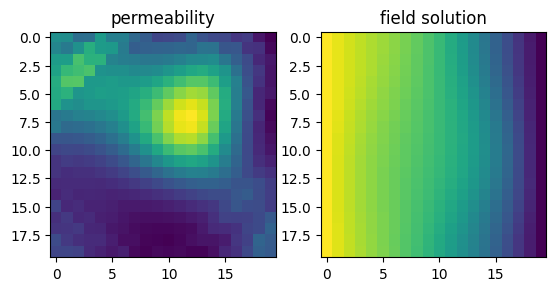

In [3]:
plt.subplot(1, 2, 1)
plt.title('permeability')
plt.imshow(k_train.squeeze(-1)[0])
plt.subplot(1, 2, 2)
plt.title('field solution')
plt.imshow(u_train.squeeze(-1)[0])
plt.show()

We now create the neural operator class. It is a very simple class, inheriting from `AbstractProblem`.

In [4]:
class NeuralOperatorSolver(AbstractProblem):
    input_variables = ['u_0']
    output_variables = ['u']
    conditions = {'data' : Condition(input_points=LabelTensor(k_train, input_variables), 
                                     output_points=LabelTensor(u_train, input_variables))}

# make problem
problem = NeuralOperatorSolver()

## Solving the problem with a FeedForward Neural Network

We will first solve the problem using a Feedforward neural network. We will use the `SupervisedSolver` for solving the problem, since we are training using supervised learning.

In [5]:
# make model
model=FeedForward(input_dimensions=1, output_dimensions=1)


# make solver
solver = SupervisedSolver(problem=problem, model=model)

# make the trainer and train
trainer = Trainer(solver=solver, max_epochs=100)
trainer.train()


/u/n/ndemo/.local/lib/python3.9/site-packages/torch/cuda/__init__.py:611: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: /u/n/ndemo/PINA/tutorials/tutorial5/lightning_logs
2023-10-17 10:41:03.316644: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-10-17 10:41:03.333768: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-17 10:41:03.383188: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enab

Training: 0it [00:00, ?it/s]

/u/n/ndemo/.local/lib/python3.9/site-packages/torch/_tensor.py:1386: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3614.)
  ret = func(*args, **kwargs)
`Trainer.fit` stopped: `max_epochs=100` reached.


The final loss is pretty high... We can calculate the error by importing `LpLoss`.

In [6]:
from pina.loss import LpLoss

# make the metric
metric_err = LpLoss(relative=True)


err = float(metric_err(u_train.squeeze(-1), solver.models[0](k_train).squeeze(-1)).mean())*100
print(f'Final error training {err:.2f}%')

err = float(metric_err(u_test.squeeze(-1), solver.models[0](k_test).squeeze(-1)).mean())*100
print(f'Final error testing {err:.2f}%')

Final error training 56.86%
Final error testing 56.82%


## Solving the problem with a Fuorier Neural Operator (FNO)

We will now move to solve the problem using a FNO. Since we are learning operator this approach is better suited, as we shall see.

In [7]:
# make model
lifting_net = torch.nn.Linear(1, 24)
projecting_net = torch.nn.Linear(24, 1)
model = FNO(lifting_net=lifting_net,
            projecting_net=projecting_net,
            n_modes=16,
            dimensions=2,
            inner_size=24,
            padding=11)


# make solver
solver = SupervisedSolver(problem=problem, model=model)

# make the trainer and train
trainer = Trainer(solver=solver, max_epochs=20)
trainer.train()


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type    | Params
----------------------------------------
0 | _loss       | MSELoss | 0     
1 | _neural_net | Network | 591 K 
----------------------------------------
591 K     Trainable params
0         Non-trainable params
591 K     Total params
2.364     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.


We can clearly see that with 1/3 of the total epochs the loss is lower. Let's see in testing.. Notice that the number of parameters is way higher than a `FeedForward` network. We suggest to use GPU or TPU for a speed up in training.

In [8]:
err = float(metric_err(u_train.squeeze(-1), solver.models[0](k_train).squeeze(-1)).mean())*100
print(f'Final error training {err:.2f}%')

err = float(metric_err(u_test.squeeze(-1), solver.models[0](k_test).squeeze(-1)).mean())*100
print(f'Final error testing {err:.2f}%')

Final error training 26.19%
Final error testing 25.89%


As we can see the loss is way lower!

## What's next?

We have made a very simple example on how to use the `FNO` for learning neural operator. Currently in **PINA** we implement 1D/2D/3D cases. We suggest to extend the tutorial using more complex problems and train for longer, to see the full potential of neural operators.